In [88]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

#Not considering the beam function as well as taking the mass of all the parameters to be unity
#and uncorrelated noise

In [89]:
#Cls and alms- l Cls and (l+1)*(l+2)/2 alms                                                                                                                                                                                                                                                                                                                                                                                                            

In [90]:
#Func to convert index n to l,m
def ntolm(n):
    lt = (np.sqrt(8.0*n+1)-1.0)/2.0
    l = int(lt)
    m = int(n-l*(l+1)/2)
    return l,m
    

In [91]:
#Function to convert l,m to n
def lmton(l,m):
    n = int(l*(l+1)/2 + m)
    return n

In [92]:
#functin to calculate the Cls of given alms
def cl_realize(lmax,almr,almi):
    Cl = np.ndarray(shape=(lmax+1))
    Cl[0]=0.0
    Cl[1]=0.0
    for l in np.arange(2,lmax+1,1):
        k = lmton(l,0)
        temp = almr[k]**2
        for m in np.arange(1,l+1,1):
            k = lmton(l,m)
            temp1 = 2*(almr[k]**2+almi[k]**2)
            temp = temp+temp1
        Cl[l]=temp/(2*l+1)
    return Cl
    

In [93]:
#Defining the gradients of potential
#w.r.to alms

def PEalm(n,cl,almr,almi,dalmr,dalmi,noise):
    pdotr = np.ndarray(shape=(n))
    pdoti = np.ndarray(shape=(n))
    for k in range(n):
        l,m = ntolm(k)
        if m==0:
            pdoti[k]=0
            pdotr[k]= almr[k]/cl[l] - (dalmr[k]-almr[k])/noise[l]
        else:
            pdoti[k]=almi[k]/cl[l] - (dalmi[k]-almi[k])/noise[l]
            pdotr[k]= almr[k]/cl[l] - (dalmr[k]-almr[k])/noise[l]
    return pdotr,pdoti        


#w.r.to Cl
def PEcl(lmax,cl,cl_realize):
    pdotcl=np.ndarray(shape=(lmax+1))
    pdotcl[0]=0
    pdotcl[1]=0
    l = np.ndarray(shape=(lmax+1))
    for i in range(lmax):
        l[i]=i
    pdotcl[2:]=(l[2:]+0.5)*(1/cl[2:])*(1-(cl_realize[2:])/cl[2:])
    return pdotcl
    
    

In [94]:
#Defining the kinetic energy
def KE(palmr,palmi,pcl,n):
    ke = np.sum(np.square(palmr[2:]))+np.sum(np.square(pcl[2:]))
    ke = ke/2.0
    ke1=0.0
    for i in range(n):
        l,m=ntolm(n)
        if m!=0:
            ke1=np.square(palmi[i])*0.5+ke1
        ke=ke+np.sum(ke1)
    return ke
    
    

In [95]:
#Defining the potential energy
def pe(nalm,cl,cl_realize,lmax,noise):
    pe = np.sum(0.5*nalm[2:]/noise[2:])
    l = np.ndarray(shape=(lmax+1))
    for i in range(lmax):
        l[i]=i
    pe = pe + (l[2:]+0.5)*((np.log(cl[2:]))+ cl_realize[2:]/cl[2:])
    pe=np.sum(pe)
    return pe
    

In [96]:
#Defining the auxiliarry varibales-momentum for Cl
def momentum_cl(lmax):
    return np.random.normal(0,1,lmax)

In [116]:
#Defining the auxiliarry varibales-momentum for alms
def momentum_alm(n):
    palm_r=np.random.normal(0,1,n)
    palm_i=np.random.normal(0,1,n)
    return palm_i, palm_r
    

In [135]:
#Trial power spectra - constant power spectrum
lmax=20
nside=lmax
l=np.arange(0,lmax+1,1)
Cl_theory=np.ndarray(shape=(lmax+1))
Cl_theory[0]=0
Cl_theory[1]=0
#constant power spectrum nope
Cl_theory[2:]=3.0
#Try exponential or some power law next

Text(0, 0.5, '$C_{l}$')

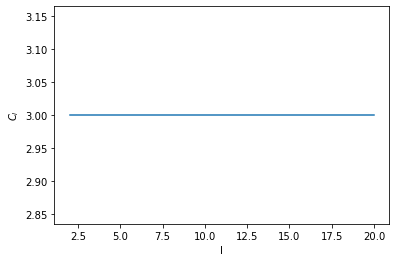

In [99]:
#Plotting theoretical power spectrum
plt.plot(l[2:],Cl_theory[2:])
plt.xlabel('l')
plt.ylabel(r'$C_{l}$')

In [100]:
#noise spectrum - constant noise
N = np.ndarray(shape=(lmax+1))
N[0]=0
N[1]=0
N[2:]=0.01

In [101]:
#Generate Realization alms for the theoretical Cl using healpy
map_sig,alm_sig=hp.synfast(cls=Cl_theory,nside=nside,lmax=lmax,alm=True,
    pol=False, pixwin=False, fwhm=0.0, sigma=None, new=False, verbose=True)
#Generate realization angular power spectrum using healpy using the alms above
Cl_realiz=hp.anafast(map_sig,lmax=lmax,alm=False, pol=False)

<ipython-input-101-8c9c0b12b139>:2: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  map_sig,alm_sig=hp.synfast(cls=Cl_theory,nside=nside,lmax=lmax,alm=True,


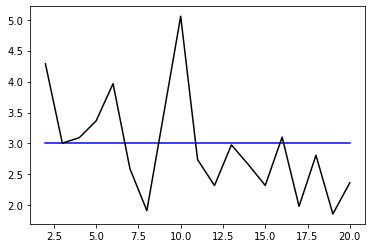

In [102]:
#Plotting the theory and the realization Cl
plt.plot(l[2:],Cl_theory[2:],color='blue')
plt.plot(l[2:],Cl_realiz[2:],color='black')
plt.xlabel('l')
plt.ylabel(r'$C_{l}$')

In [103]:
#To define the data we need noise realization too
map_noise,alm_noise=hp.synfast(cls=N,nside=nside,lmax=lmax,alm=True,
    pol=False, pixwin=False, fwhm=0.0, sigma=None, new=False, verbose=True)
#Generate noise realization angular power spectrum using healpy
noise_realiz=hp.anafast(map_noise,lmax=lmax,alm=False, pol=False)

<ipython-input-103-5657559d5de0>:2: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  map_noise,alm_noise=hp.synfast(cls=N,nside=nside,lmax=lmax,alm=True,


In [104]:
#DAta=signal plus noise
map_data=map_sig+map_noise
alm_data=alm_sig+alm_noise

In [105]:
#Getting the data Cl
Cl_data=hp.anafast(map_data,lmax=lmax,alm=False,pol=False)

In [106]:
#compute data angular power spectrum Shabbirs method-basically gives the same values as anafast
#data_cl = hp.alm2cl( alms1 = alm_data, alms2=None, lmax=lmax, nspec=None)


Text(0, 0.5, '$C_{l}$')

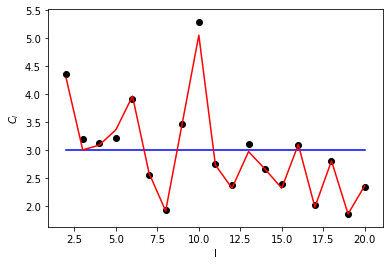

In [107]:
#Plottind Cl_data,Cl_realization and Cl_theory
plt.plot(l[2:],Cl_theory[2:],color='blue',label='theory')
plt.plot(l[2:],Cl_realiz[2:],color='red',label='realization')
plt.scatter(l[2:],Cl_data[2:],color='black',label='data')
plt.xlabel('l')
plt.ylabel(r'$C_{l}$')

In [108]:
#No.of alms(negative m's are not counted because of contraint)
no_alms = int((lmax+1)*(lmax+2)/2)#Momentum and position variables of alms

In [109]:
#main program
#initialise variables
epsi=0.001
lp_steps=200
N_samples = 1000
kount = 0    #to count the accepted steps

In [110]:
#The mcmc chain is stored in these arrays
sample_almr =np.ndarray(shape=(no_alms,N_samples)) 
sample_almi =np.ndarray(shape=(no_alms,N_samples)) 
sample_cl = np.ndarray(shape=(lmax+1,N_samples))

In [111]:
#Getting data alm from helpy and arranging it into real and complex arrays
dlm = np.ndarray(shape = (lmax+1, lmax+1), dtype = complex)

d_almr=np.ndarray(shape=(no_alms))
d_almi=np.ndarray(shape=(no_alms))

#first read the 1D indexed alms of healpy, arranged according to healpy convention
index = 0
for m in np.arange(0, lmax+1, 1):
    for l in np.arange(m, lmax+1, 1):
        dlm[l,m] = alm_data[index]
        index += 1
index = 0
for i in np.arange(0, lmax+1, 1):
    for j in np.arange(0, i + 1, 1):
        d_almr[index] = np.real(dlm[i,j])
        d_almi[index] = np.imag(dlm[i,j])
        index += 1


In [114]:
#array for the momentum chain
p_almr = np.ndarray(shape=(no_alms,N_samples)) 
p_almi = np.ndarray(shape=(no_alms,N_samples)) 
p_cl = np.ndarray(shape=(lmax+1,N_samples)) 
kr = np.ndarray(shape=(no_alms))
ki = np.ndarray(shape=(no_alms))
k1r = np.ndarray(shape=(no_alms))
k1i = np.ndarray(shape=(no_alms))

#initial value for the samples
sample_almr[:,0]=1.0
sample_almi[:,0]=1.0
sample_cl[:,0]=1.0

#temporaty variables for leapfrog
ptemp_almr=np.ndarray(shape=(no_alms,lp_steps))
ptemp_almi=np.ndarray(shape=(no_alms,lp_steps))
ptemp_cl=np.ndarray(shape=(lmax+1,lp_steps))
temp_almr=np.ndarray(shape=(no_alms))
temp_almi=np.ndarray(shape=(no_alms))
temp_cl=np.ndarray(shape=(lmax+1))

xtemp_almr=np.ndarray(shape=(no_alms,lp_steps))
xtemp_almi=np.ndarray(shape=(no_alms,lp_steps))
xtemp_cl=np.ndarray(shape=(lmax+1,lp_steps))

In [117]:
#The main program/the main loop
for i in range(0,N_samples-1):
    #initialising the auxiliary variable at every step
    p_almi[:,i],p_almr[:,i]=momentum_alm(no_alms)
    p_cl[:,i] = momentum_cl(lmax+1)
    
    #starting the leapfrog process
    xtemp_almr[:,0]=sample_almr[:,i]
    xtemp_almi[:,0]=sample_almi[:,i]
    xtemp_cl[:,0]=sample_cl[:,i]
    ptemp_almr[:,0]=p_almr[:,i]
    ptemp_almi[:,0]=p_almi[:,i]
    ptemp_cl[:,0]=p_cl[:,i]
    dcl = cl_realize(lmax,d_almr-sample_almr[:,i],d_almi-sample_almi[:,i])
    for j in range(0,lp_steps-1):
        kr,ki = PEalm(no_alms,sample_cl[:,i],xtemp_almr[:,j],xtemp_almi[:,j],d_almr,d_almi,N)
        temp_almr = ptemp_almr[:,j]-epsi*kr/2
        temp_almi = ptemp_almi[:,j]-epsi*ki/2
        xtemp_almr[:,j+1] = xtemp_almr[:,j]+epsi*temp_almr
        xtemp_almi[:,j+1] = xtemp_almi[:,j]+epsi*temp_almi
        k1r,k1i = PEalm(no_alms,sample_cl[:,i],xtemp_almr[:,j+1],xtemp_almi[:,j+1],d_almr,d_almi,N)
        ptemp_almr[:,j+1] = temp_almr - (epsi*k1r/2)
        ptemp_almi[:,j+1] = temp_almi - (epsi*k1i/2)
        
        kcl = PEcl(lmax,xtemp_cl[:,j],cl_realize(lmax,sample_almr[:,i],sample_almi[:,i]))
        temp_cl = ptemp_cl[:,j]-epsi*kcl/2
        xtemp_cl[:,j+1]=xtemp_cl[:,j]+epsi*temp_cl
        k1cl = PEcl(lmax,xtemp_cl[:,j+1],cl_realize(lmax,sample_almr[:,i],sample_almi[:,i]))
        ptemp_cl[:,j+1]=temp_cl - (epsi*k1cl/2)
        
    #Metropolis acceptance
    kin = KE(p_almr[:,i],p_almi[:,i],p_cl[:,i],no_alms)
    pot = pe(dcl,sample_cl[:,0],cl_realize(lmax,sample_almr[:,i],sample_almi[:,i]),lmax,N)
    kin_star = KE(ptemp_almr[:,lp_steps-1],ptemp_almi[:,lp_steps-1],p_cl[:,lp_steps-1],no_alms)
    pot_star = pe(dcl,xtemp_cl[:,lp_steps-1],cl_realize(lmax,xtemp_almr[:,lp_steps-1],xtemp_almi[:,lp_steps-1]),lmax,N)
    H = kin+pot
    Hstar = kin_star+pot_star
    ratio = Hstar/H
    alpha = np.random.uniform()
    if alpha<min(1,ratio):
        sample_almr[:,i+1]=xtemp_almr[:,lp_steps-1]
        sample_almi[:,i+1]=xtemp_almi[:,lp_steps-1]
        sample_cl[:,i+1] = xtemp_cl[:,lp_steps-1]
        kount = kount +1
    else:
        sample_almr[:,i+1]=sample_almr[:,i]
        sample_almi[:,i+1]=sample_almi[:,i]
        sample_cl[:,i+1] = sample_cl[:,i]
            
        
print('Ratio of samples accepted to the total no.of samples')
print(kount/N_samples)
        


    
    
    
        
    

<ipython-input-93-841fe245b3ae>:11: RuntimeWarning: divide by zero encountered in double_scalars
  pdotr[k]= almr[k]/cl[l] - (dalmr[k]-almr[k])/noise[l]
<ipython-input-93-841fe245b3ae>:13: RuntimeWarning: divide by zero encountered in double_scalars
  pdoti[k]=almi[k]/cl[l] - (dalmi[k]-almi[k])/noise[l]
<ipython-input-93-841fe245b3ae>:14: RuntimeWarning: divide by zero encountered in double_scalars
  pdotr[k]= almr[k]/cl[l] - (dalmr[k]-almr[k])/noise[l]
<ipython-input-117-e6c7d699de2f>:22: RuntimeWarning: invalid value encountered in subtract
  ptemp_almr[:,j+1] = temp_almr - (epsi*k1r/2)
<ipython-input-117-e6c7d699de2f>:23: RuntimeWarning: invalid value encountered in subtract
  ptemp_almi[:,j+1] = temp_almi - (epsi*k1i/2)


Ratio of samples accepted to the total no.of samples
0.999


In [118]:
burnin = 200
Cl_bayes = np.ndarray(shape=(lmax+1))

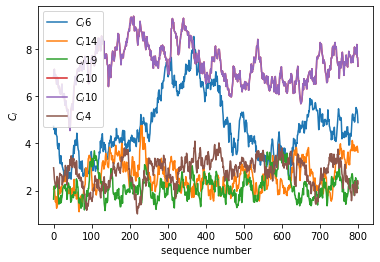

In [163]:
#Plotting a few Cls
for i in range(6):
    n = int(np.random.uniform(0,20))
    plt.plot(sample_cl[n,burnin:],label="$C_{l}$"+str(n))
plt.xlabel('sequence number')
plt.ylabel('$C_{l}$')   
plt.legend()

Text(0, 0.5, 'Density')

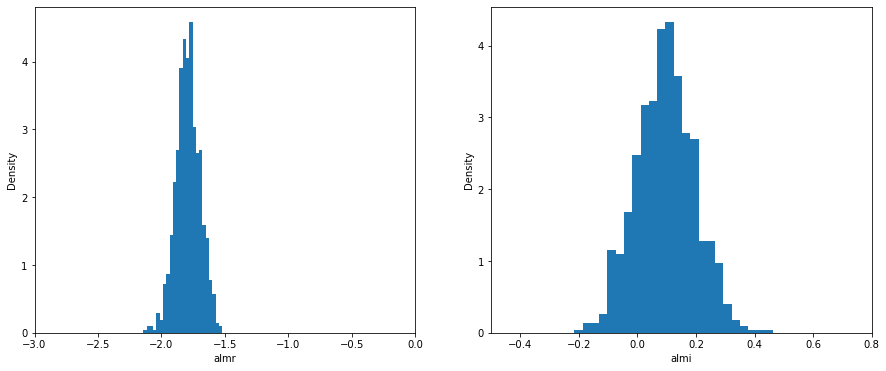

In [173]:
#plotting the chain for alm
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
ll=10
mm=10
nn = lmton(ll,mm)
plt.hist(sample_almr[n,burnin:],bins='auto',density=True)
plt.xlim(-3.0,0.0)
plt.xlabel('almr')
plt.ylabel('Density')
plt.subplot(1,2,2)
plt.hist(sample_almi[n,burnin:],bins='auto',density=True)
plt.xlim(-0.5,0.8)
plt.xlabel('almi')
plt.ylabel('Density')

In [164]:
#Considering only the mean of each Cl from the chin generated
for k in range(lmax+1):
    Cl_bayes[k] = np.mean(sample_cl[k,burnin:])
#cosmic variance
std = np.sqrt(2/(2*l[2:]+1))   

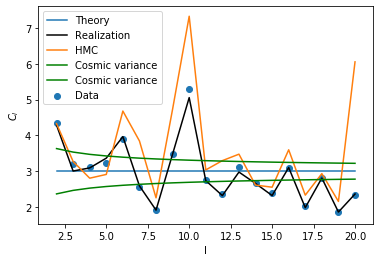

In [175]:
#summary stats - plotting the mean of the Cl chains

plt.plot(l[2:],Cl_theory[2:],label='Theory')
plt.plot(l[2:],Cl_realiz[2:],color='black',label='Realization')
plt.scatter(l[2:],Cl_data[2:],label='Data')
plt.plot(l[2:],Cl_bayes[2:],label='HMC')
plt.plot(l[2:],Cl_theory[2:]+std,color='green',label='Cosmic variance')
plt.plot(l[2:],Cl_theory[2:]-std,color='green',label='Cosmic variance')
plt.xlabel('l')
plt.ylabel(r'$C_{l}$')
plt.legend()